In [6]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [7]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [8]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   GLDD    1259 non-null   float64
 3   HSON    1259 non-null   float64
 4   ISSC    1259 non-null   float64
 5   KRNT    1259 non-null   float64
 6   RCII    1259 non-null   float64
 7   SAIA    1259 non-null   float64
 8   AMD     1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  APPS    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  AUDC    1259 non-null   float64
 13  DSGX    1259 non-null   float64
 14  TTD     1259 non-null   float64
 15  TSLA    1259 non-null   float64
 16  CHDN    1259 non-null   float64
 17  CLAR    1259 non-null   float64
 18  FIVE    1259 non-null   float64
 19  FOXF    1259 non-null   float64
 20  HTHT    1259 non-null   float64
 21  LULU    1259 non-nu

## Function that saves dataframe to CSV

In [9]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [10]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [11]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [12]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [13]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [14]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [15]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [16]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [17]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [18]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.0287595,0.209272,0.0153755,0.031024,0.004788,0.031346,0.0284165,0.001022,0.0279335,
               0.035112,0.109396,0.067025,0.0548345,0.00399,0.0517125,0.030421,0.008134,0.021438,
               0.003633,0.00768,0.004057,0.024637,0.058685,0.0100675,0.031375,0.00217,0.0201475,
               0.0064475,0.0539625,0.056335,0.010815,0.15,0]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696597,11.863170,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.319280,2.235230,...,0.007248,1.505220,0.231530,0.131129,1.754835,0.053751,15.529626,0.0,56.134506,NaN
2017-01-04,2.711298,11.912385,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.319280,2.259808,...,0.007356,1.547731,0.234625,0.129510,1.819620,0.052128,15.551699,0.0,56.367591,0.004152
2017-01-05,2.714712,11.771578,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.313973,2.273502,...,0.007335,1.535441,0.231014,0.131129,1.865252,0.053426,15.345676,0.0,56.087183,-0.004975
2017-01-06,2.744638,11.770210,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.316207,2.347940,...,0.007400,1.584601,0.230949,0.131129,1.864688,0.053534,15.233837,0.0,56.249071,0.002886
2017-01-09,2.681371,11.705959,0.066883,0.434336,0.015440,0.418469,0.278048,0.045070,0.320956,2.346886,...,0.007617,1.619255,0.230305,0.127891,1.821874,0.055697,15.155844,0.0,56.178389,-0.001257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.022473,74.346030,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.311815,24.473064,...,0.011718,6.197774,1.469385,3.418524,15.089892,0.238471,57.378337,0.0,356.438891,0.022026
2021-12-28,6.074872,74.563464,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.278015,23.953407,...,0.011935,6.166142,1.407489,3.277143,14.296133,0.237281,57.583388,0.0,354.151779,-0.006417
2021-12-29,6.080885,75.435295,0.240780,0.870533,0.031314,4.839196,1.402638,0.342789,4.141421,23.800319,...,0.011588,6.205228,1.421480,3.210229,14.528796,0.232522,57.616319,0.0,354.935093,0.002212


## Get old data for portfolio

In [19]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696597,11.863170,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.319280,2.235230,...,0.007248,1.505220,0.231530,0.131129,1.754835,0.053751,15.529626,0.0,56.134506,NaN
2017-01-04,2.711298,11.912385,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.319280,2.259808,...,0.007356,1.547731,0.234625,0.129510,1.819620,0.052128,15.551699,0.0,56.367591,0.004152
2017-01-05,2.714712,11.771578,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.313973,2.273502,...,0.007335,1.535441,0.231014,0.131129,1.865252,0.053426,15.345676,0.0,56.087183,-0.004975
2017-01-06,2.744638,11.770210,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.316207,2.347940,...,0.007400,1.584601,0.230949,0.131129,1.864688,0.053534,15.233837,0.0,56.249071,0.002886
2017-01-09,2.681371,11.705959,0.066883,0.434336,0.015440,0.418469,0.278048,0.045070,0.320956,2.346886,...,0.007617,1.619255,0.230305,0.127891,1.821874,0.055697,15.155844,0.0,56.178389,-0.001257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.022473,74.346030,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.311815,24.473064,...,0.011718,6.197774,1.469385,3.418524,15.089892,0.238471,57.378337,0.0,356.438891,0.022026
2021-12-28,6.074872,74.563464,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.278015,23.953407,...,0.011935,6.166142,1.407489,3.277143,14.296133,0.237281,57.583388,0.0,354.151779,-0.006417
2021-12-29,6.080885,75.435295,0.240780,0.870533,0.031314,4.839196,1.402638,0.342789,4.141421,23.800319,...,0.011588,6.205228,1.421480,3.210229,14.528796,0.232522,57.616319,0.0,354.935093,0.002212


## Forecasting

In [20]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [21]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [22]:
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696597,11.863170,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.319280,2.235230,...,0.007248,1.505220,0.231530,0.131129,1.754835,0.053751,15.529626,0.0,56.134506,NaN
2017-01-04,2.711298,11.912385,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.319280,2.259808,...,0.007356,1.547731,0.234625,0.129510,1.819620,0.052128,15.551699,0.0,56.367591,0.004152
2017-01-05,2.714712,11.771578,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.313973,2.273502,...,0.007335,1.535441,0.231014,0.131129,1.865252,0.053426,15.345676,0.0,56.087183,-0.004975
2017-01-06,2.744638,11.770210,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.316207,2.347940,...,0.007400,1.584601,0.230949,0.131129,1.864688,0.053534,15.233837,0.0,56.249071,0.002886
2017-01-07,2.744638,11.770210,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.316207,2.347940,...,0.007400,1.584601,0.230949,0.131129,1.864688,0.053534,15.233837,0.0,56.249071,0.002886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.022473,74.346030,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.311815,24.473064,...,0.011718,6.197774,1.469385,3.418524,15.089892,0.238471,57.378337,0.0,356.438891,0.022026
2021-12-28,6.074872,74.563464,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.278015,23.953407,...,0.011935,6.166142,1.407489,3.277143,14.296133,0.237281,57.583388,0.0,354.151779,-0.006417
2021-12-29,6.080885,75.435295,0.240780,0.870533,0.031314,4.839196,1.402638,0.342789,4.141421,23.800319,...,0.011588,6.205228,1.421480,3.210229,14.528796,0.232522,57.616319,0.0,354.935093,0.002212


In [23]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [24]:
tot_port_df

,Total
Date,
2017-01-03,56.134506
2017-01-04,56.367591
2017-01-05,56.087183
2017-01-06,56.249071
2017-01-07,56.249071
...,...
2021-12-27,356.438891
2021-12-28,354.151779
2021-12-29,354.935093


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


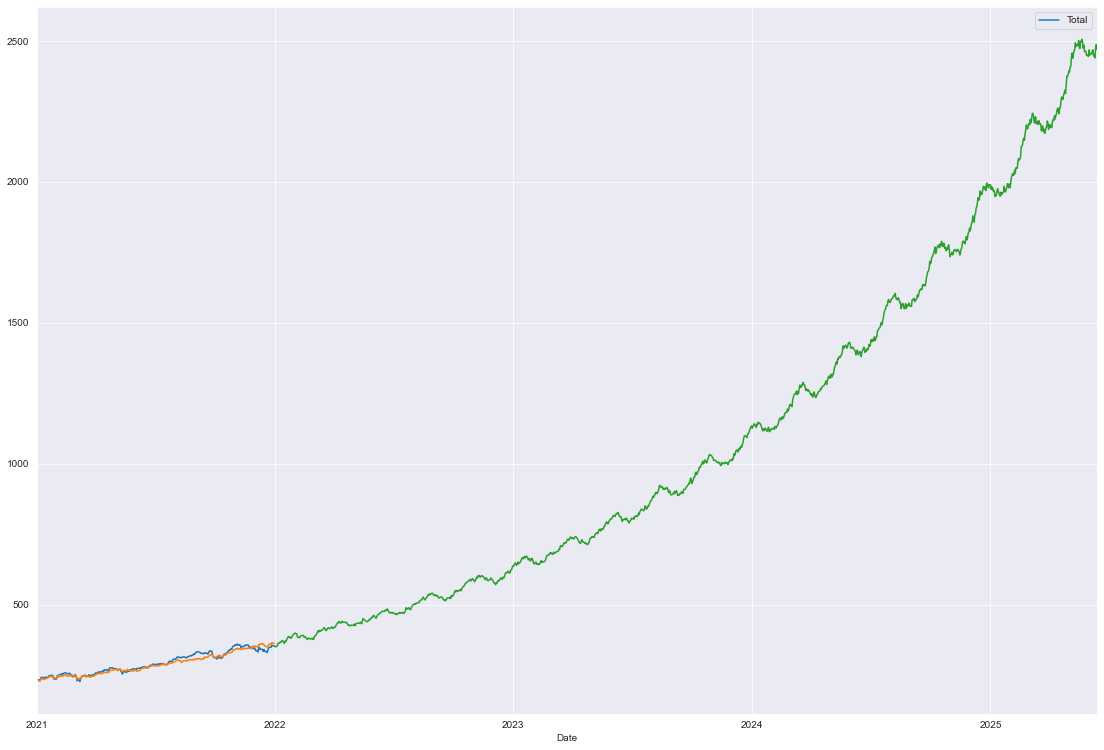

In [25]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [26]:
forecast

2021-12-31     353.055484
2022-01-01     352.066955
2022-01-02     350.703887
2022-01-03     350.983150
2022-01-04     354.090536
                 ...     
2025-06-09    2449.070134
2025-06-10    2439.770692
2025-06-11    2473.475898
2025-06-12    2487.181057
2025-06-13    2470.551138
Freq: D, Length: 1261, dtype: float64

In [27]:
forecast_df = pd.DataFrame(forecast)

In [28]:
forecast_df

,0
2021-12-31,353.055484
2022-01-01,352.066955
2022-01-02,350.703887
2022-01-03,350.983150
2022-01-04,354.090536
...,...
2025-06-09,2449.070134
2025-06-10,2439.770692
2025-06-11,2473.475898
2025-06-12,2487.181057


In [29]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [30]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.002800
2022-01-02,-0.006661
2022-01-03,-0.005870
2022-01-04,0.002932
...,...
2025-06-09,5.936785
2025-06-10,5.910446
2025-06-11,6.005913
2025-06-12,6.044731


In [31]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  47.567316
